In [1]:
from tensorflow.keras.utils import normalize
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import shutil
shutil.copyfile("/content/drive/MyDrive/Bitirme/data.npy","/content/data.npy",)
shutil.copyfile("/content/drive/MyDrive/Bitirme/data_y.npy","/content/data_y.npy",)

'/content/data_y.npy'

In [56]:
data = np.load('/content/data.npy')
data_y = np.load('/content/data_y.npy')

In [57]:
data=data.reshape(1026,80,80)
data_y=data_y.reshape(1026,80,80)

In [58]:
image_dataset=data
mask_dataset=data_y

In [59]:
test_dataset=image_dataset[800:1026]
test_mask_dataset=mask_dataset[800:1026]

In [60]:
image_dataset=image_dataset[:800]
mask_dataset=mask_dataset[:800]

In [61]:
mask_dataset.shape

(800, 80, 80)

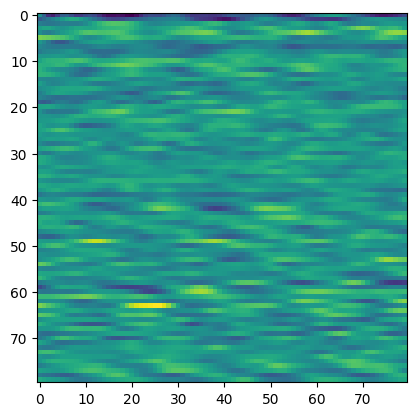

In [62]:
plt.imshow(mask_dataset[1])

In [15]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (800, 80, 80)
Mask data shape is:  (800, 80, 80)
Max pixel value in image is:  283.57459810075176
Labels in the mask are :  [-121.14302883 -120.25849718 -120.01650525 ...   96.8267962    96.96643032
   97.11078802]


In [63]:
def scaler(data):
  scaler = MinMaxScaler()
  count=0
  for i in data:
    scaled_data = scaler.fit_transform(i)
    data[count]=scaled_data
    count+=1
  count=0


In [64]:
for i in (image_dataset,mask_dataset):
  scaler(i)

In [65]:
  scaler = MinMaxScaler()
  count=0
  for i in test_dataset:
    scaled_data = scaler.fit_transform(i)
    test_dataset[count]=scaled_data
    count+=1
  count=0

  scaler = MinMaxScaler()
  count=0
  for i in test_mask_dataset:
    scaled_data1 = scaler.fit_transform(i)
    test_mask_dataset[count]=scaled_data1
    count+=1
  count=0

In [66]:
image_dataset = np.expand_dims(image_dataset, axis = 3)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)
test_mask_dataset= np.expand_dims(test_mask_dataset, axis = 3)
test_dataset= np.expand_dims(test_dataset, axis = 3)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2)

In [68]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [69]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = Activation("elu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("elu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    x = conv_block(x, num_filters)
    p = MaxPool2D((2, 2))(x)
    x = Dropout(0.5)(x)
    return x, p   

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    x = Dropout(0.5)(x)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(3, 1, padding="same", activation='linear')(d4)
    model = Model(inputs, outputs, name="U-Net")
    return model

In [70]:
model = build_unet(input_shape)

In [71]:
from keras import losses

In [72]:
model.load_weights("/content/drive/MyDrive/Bitirme/model")

In [73]:

model.compile(optimizer=Adam(learning_rate = 1e-4), loss='MSE', metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 80, 80, 64)   640         ['input_2[0][0]']                
                                                                                                  
 activation_26 (Activation)     (None, 80, 80, 64)   0           ['conv2d_27[0][0]']              
                                                                                                  
 conv2d_28 (Conv2D)             (None, 80, 80, 64)   36928       ['activation_26[0][0]']          
                                                                                              

In [74]:
history = model.fit(X_train, y_train, 
                    batch_size = 2, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test),
                    shuffle=False)


Epoch 1/20
320/320 [==============================] - 22s 58ms/step - loss: 0.0024 - accuracy: 0.0111 - val_loss: 3.0065e-04 - val_accuracy: 0.0117
Epoch 2/20
320/320 [==============================] - 18s 57ms/step - loss: 0.0024 - accuracy: 0.0111 - val_loss: 3.0530e-04 - val_accuracy: 0.0115
Epoch 3/20
320/320 [==============================] - 18s 57ms/step - loss: 0.0024 - accuracy: 0.0110 - val_loss: 3.0286e-04 - val_accuracy: 0.0115
Epoch 4/20
320/320 [==============================] - 18s 57ms/step - loss: 0.0024 - accuracy: 0.0110 - val_loss: 3.0449e-04 - val_accuracy: 0.0115
Epoch 5/20
320/320 [==============================] - 19s 60ms/step - loss: 0.0024 - accuracy: 0.0108 - val_loss: 3.0733e-04 - val_accuracy: 0.0116
Epoch 6/20
320/320 [==============================] - 19s 58ms/step - loss: 0.0024 - accuracy: 0.0108 - val_loss: 3.0615e-04 - val_accuracy: 0.0114
Epoch 7/20
320/320 [==============================] - 18s 58ms/step - loss: 0.0024 - accuracy: 0.0108 - val_loss

In [75]:
model.save("/content/drive/MyDrive/Bitirme/model")

In [76]:
y_pred=model.predict(test_dataset)

8/8 [==============================] - 1s 86ms/step


(1, 80, 80, 1)


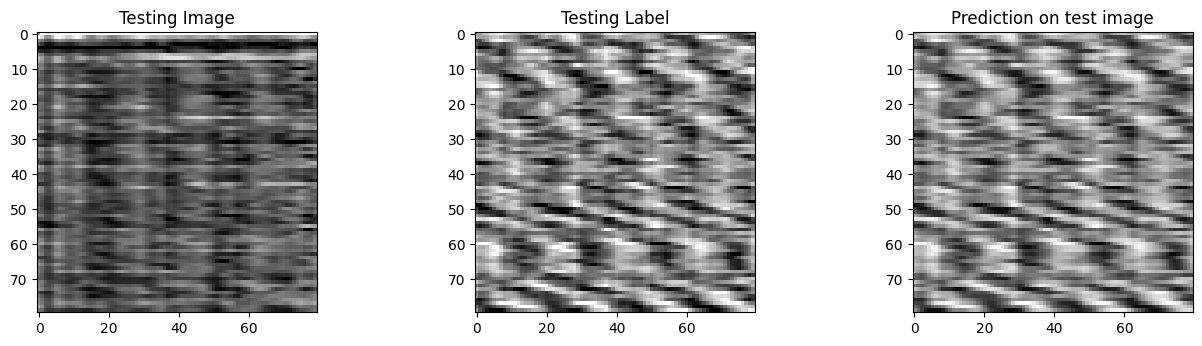

In [77]:
import random
test_img_number = random.randint(0, len(test_dataset)-1)
test_img = test_dataset[test_img_number]
ground_truth=test_mask_dataset[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred[test_img_number,:,:,0], cmap='gray')

plt.show()

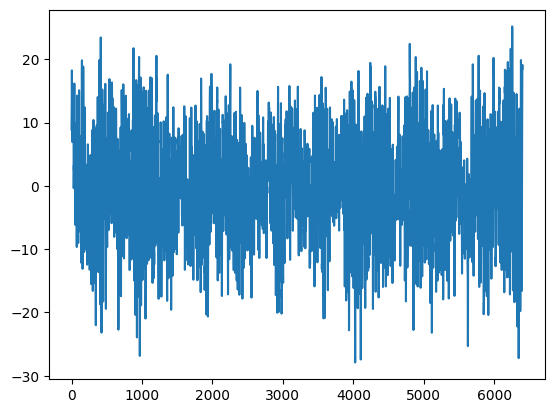

In [78]:
plt.plot(np.reshape(scaler.inverse_transform(y_pred[test_img_number,:,:,0]),(6400,1)))

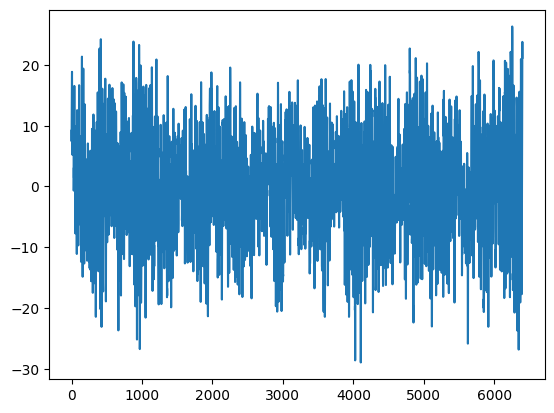

In [79]:
plt.plot(np.reshape(scaler.inverse_transform(ground_truth[:,:,0]),(6400,1)))

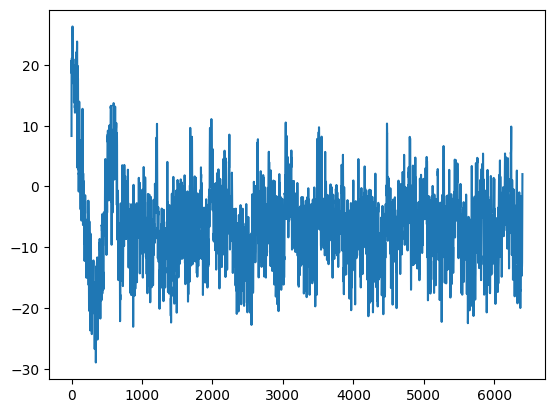

In [80]:
plt.plot(np.reshape(scaler.inverse_transform(test_img[:,:,0]),(6400,1)))

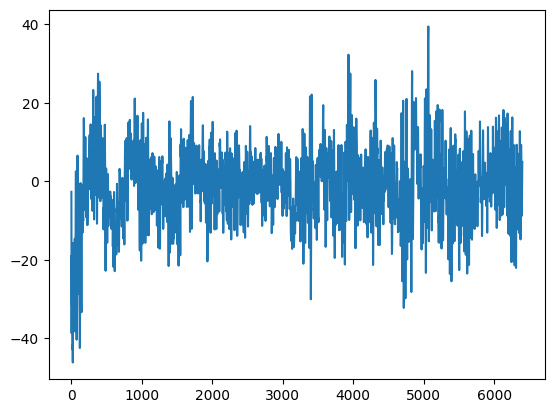

In [51]:
plt.plot(np.reshape((data_y[1]),(6400)))

In [39]:
truth=(np.reshape(ground_truth[:,:,0],(6400,1)))
pred=(np.reshape(y_pred[test_img_number,:,:,0],(6400,1)))

In [40]:
scipy.io.savemat('truth.mat', {'truth': truth})
scipy.io.savemat('pred.mat', {'pred': pred})